In [141]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


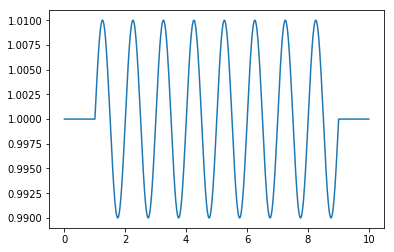

In [166]:
xmax = 10.
nx = 1000
dx = xmax / nx
x0 = np.linspace(0., xmax, num=nx)
z0 = np.zeros(nx)

factor = 1



for i in range(nx):
    z0[i] = 0.01*np.sin(factor*2.*math.pi*(i*dx)) + 1
    
T = int(1/dx)
    
z0[0:T] = 1.
z0[9*T:] = 1

plt.plot(x0,z0)

In [177]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

# Match 3d
#a = 0.00003
#b = 2.

#match 2d
a_2d = 0.00005
b_2d = 5.

base_elev = 1

1.3569913235179714
0.5113522953084922


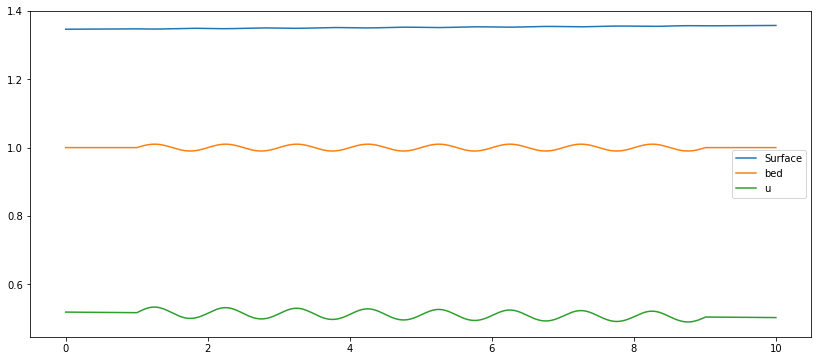

<Figure size 1008x432 with 0 Axes>

In [171]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32 + base_elev, q32cm)
model.set_inital_conditions(sOut32 + base_elev, 0.0)
model.set_controller(tfinal = 300, num_output_times=3)
model.run()

h = model.get_hf()
surf = h + z0
u = model.get_uf()

fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf, label='Surface')
plt.plot(x0, z0, label='bed')
plt.plot(x0, u, label='u')
plt.legend()
fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.01
Grid nx = 1000
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.4886217148893809 - Elevation 1.3512188782632213
Courant number: max 1404.4515922078817, mean0.452499292875253
Time step: 10.0 mins - uavg: 0.4992483509469623 - Elevation 1.3511806567443267
Courant number: max 805.195256840882, mean0.40265148816342716
Time step: 15.0 mins - uavg: 0.5058687813459166 - Elevation 1.351135008713674
Courant number: max 45.978986419555014, mean-0.43838143430632703
Time step: 20.0 mins - uavg: 0.5063932731630031 - Elevation 1.3511190042983503
Courant number: max 13.056870254865013, mean0.030022568417478652
Time step: 25.0 mins - uavg: 0.506221393304904 - Elevation 1.3511096345063014
Courant number: max 9.283336521080711, mean0.008947430704599349
Time step: 30.0 mins - uavg: 0.5066679851739032 - Elevation

Text(0, 0.5, 'z (m)')

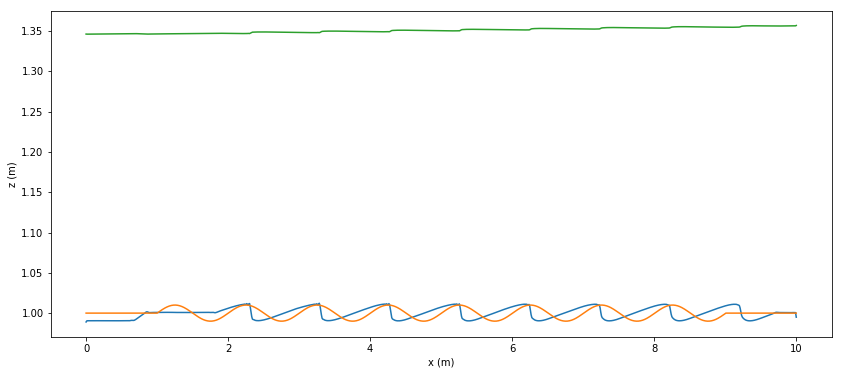

In [131]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*300     # Runtime in seconds
dt = 10.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5


run_name = 'dune_5_q_{0}_h_{1}_sine'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)



model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32 + base_elev)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.EulerWenoModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()



model.set_grass_parameters(a_2d,b_2d)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [133]:
verts = np.load('_output/{0}_verts.npy'.format(run_name))



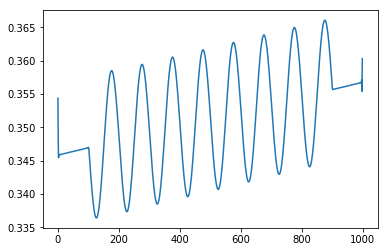

In [134]:
plt.plot(verts[0,:,4])

TypeError: list indices must be integers or slices, not tuple

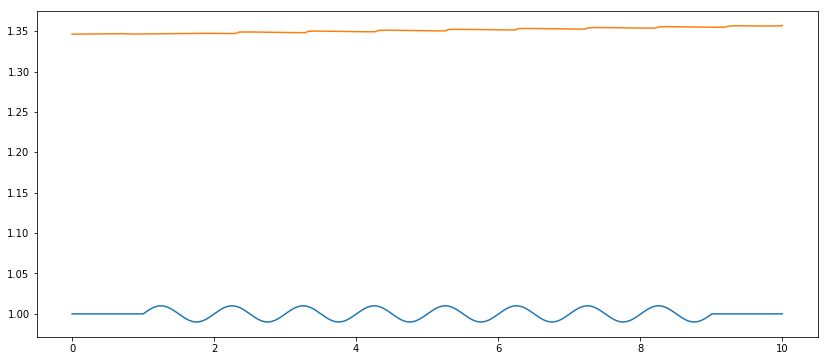

In [132]:
#self._verts.append(list(zip(self._xc.copy(),self._zc.copy(), u.copy(), q.copy(), h.copy(), qbedload.copy())))

fig = plt.figure(figsize=(14, 6))
#plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

qbedload = verts[0,:,5]
u = verts[0,:,2] 

plt.plot(x0, u, label='u')
plt.plot(x0, qbedload*10000, label='bedload')

plt.legend()
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [136]:
verts.shape

(59, 1000, 6)

In [123]:
zf = verts[238,100:900,2]

In [124]:
zf.max() - zf.min()

0.043928137598631956

In [125]:
z0.max() - z0.min()

0.020000000000000018

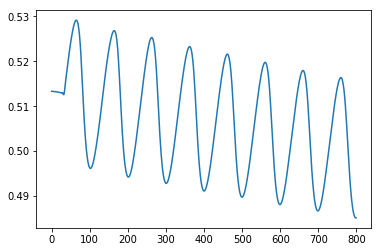

In [126]:
plt.plot(zf)

(0.85, 1.15)

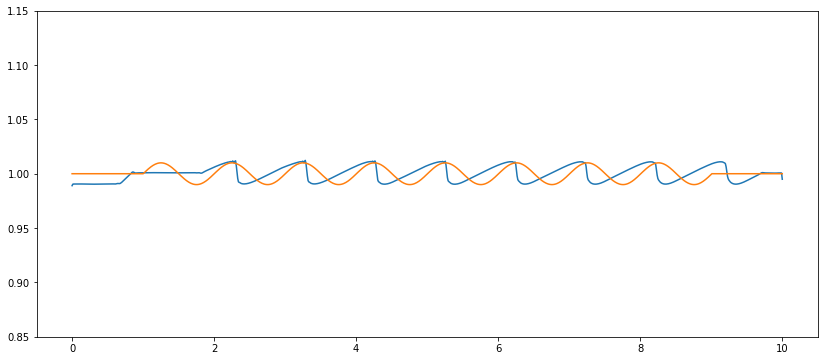

In [135]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)

plt.ylim([0.85, 1.15])

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.01
Grid nx = 1000
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.5078631196486552 - Elevation 1.3511942576045328
Courant number: max 226.74328977282215, mean0.07942502173929755
Time step: 10.0 mins - uavg: 0.5096984986273013 - Elevation 1.351076810064505
Courant number: max 34.60943641845635, mean0.045708475199414685
Time step: 15.0 mins - uavg: 0.5122433417107182 - Elevation 1.3510194572787386
Courant number: max 22.232126647873322, mean-0.150257992797079
Time step: 20.0 mins - uavg: 0.514637003801094 - Elevation 1.351001294254792
Courant number: max 42.09913667761697, mean0.10366813010396088
Time step: 25.0 mins - uavg: 0.516522155209346 - Elevation 1.3510079551920975
Courant number: max 9.077429547488123, mean0.044937251803204674
Time step: 30.0 mins - uavg: 0.5177779973468224 - Elevation 1

Text(0, 0.5, 'z (m)')

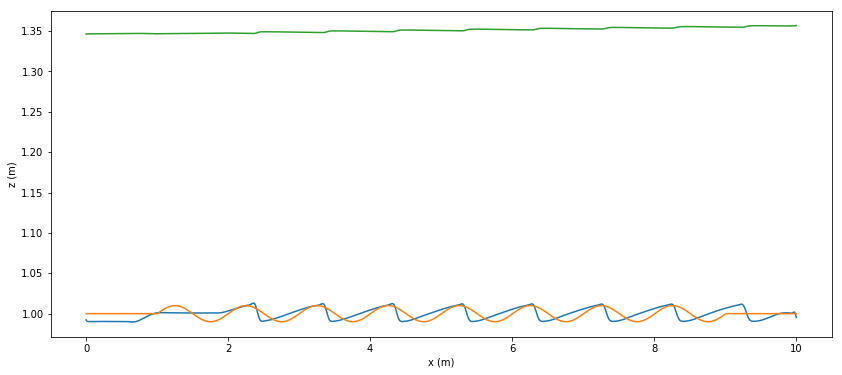

In [190]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*300     # Runtime in seconds
dt = 10.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5


run_name = 'dune_5_q_{0}_h_{1}_sine_test'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)



model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32 + base_elev)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.MacCormackModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = True, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()



model.set_grass_parameters(a_2d,b_2d)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

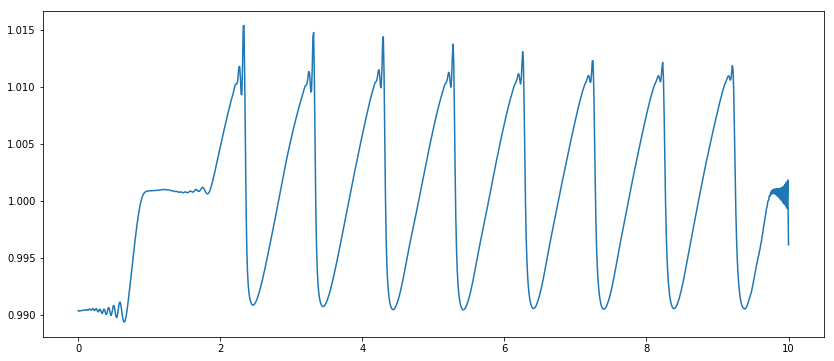

In [188]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)